##Clase

In [99]:
import math
import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter
from copy import deepcopy

class tarea1:

  def __init__(self, N, M, modos=None):
    self.n = N
    self.m = M
    self.modos = modos  # modos = [0,1,2,3] -> modos[0] = metodo para calcular, 1=
    self.h = [1, 0]
    self.v = [0, 1]
    self.routes = None
    self.ccomb_performance = None
    self.sim_performance = None
    self.both_performance = None
    self.ccomb_flag = False
    self.sim_flag = False

    print(f"Grilla iniciada de dimensiones {N}x{M}")

  def check(self, N=None, M=None):
    if (N + M) <= 3:
      raise Exception("La suma de N y M debe ser mayor o igual a 3")
    return 0

  def predet(self, N, M):
    n = N if N is not None else self.n
    m = M if M is not None else self.m
    self.check(n, m)
    return n, m

  def tomar_tiempo(func):
    def new(*args, **kwargs):
      t_i = perf_counter()
      result = func(*args, **kwargs)
      t_f = perf_counter()
      return [result, t_f - t_i]
    return new

  # Metodo 1 ################################################################
  def ccomb_route(self, n: int = None, m: int = None):
    n, m = self.predet(n, m)
    return math.comb(n + m - 2, n - 1)

  # Metodo 2 #################################################################

  def sim_route(self, N: int = None, M: int = None, get_route: bool = False):
    n, m = self.predet(N, M)
    toda_ruta = {}

    # INICIALIZACION
    historial = [[np.array([0, 0]), self.v, 1]]
    last = [0, 0]
    conteo = 0

    while historial:
      his = historial[-1]
      border_case = [his[0][0] == m - 1, his[0][1] == n - 1]

      # EN META
      if all(border_case):
        # SUMAR AL CONTEO
        conteo += 1
        if get_route:
          toda_ruta[conteo] = deepcopy(historial)

        # PIVOTEAR Y DAR PASO
        j = 0
        while historial:
          his = historial[-1]
          j += 1

          # VARIACION VIABLE
          if his[2] == 1:

            # CAMBIO A MOV. HORIZONTAL
            if last == self.v:
              historial.pop()
              historial.append([his[0], his[1], 0])
              historial.append([his[0] + self.h, self.h, 0 if (his[0][0] + 1 == m - 1) else 1])
              last = his[1]
              break

            # CAMBIO A MOV. VERTICAL
            else:
              historial.pop()
              historial.append([his[0], his[1], 0])
              historial.append([his[0] + self.v, self.v, 0 if (his[0][1] + 1 == n - 1) else 1])
              last = his[1]
              break

          # VARIACION INVIABLE
          else:
            last = his[1]
            historial.pop()

        if not historial:
          if get_route:
            return [conteo, toda_ruta]
          else:
            return conteo
        continue

      # MOVERSE
      else:
        # EN BORDE
        if any(border_case):

          # BORDE HORIZONTAL
          if border_case[1]:
            historial.append([his[0] + self.h, self.h, 0])
            continue

          # BORDE VERTICAL
          else:
            historial.append([his[0] + self.v, self.v, 0])
            continue

        # AVANCE LIBRE
        else:
          # AVANCE HORIZONTAL
          if all(his[0] == m - 1):
            historial.append([his[0] + self.h, self.h, 0 if (his[0][0] + 1 == m - 1) else 1])
            continue

          # AVANCE VERTICAL
          else:
            historial.append([his[0] + self.v, self.v, 0 if (his[0][1] + 1 == n - 1) else 1])
            continue

  @tomar_tiempo
  def route_and_time(self, N: int = None, M: int = None, method: str = None):
    n, m = self.predet(N, M)

    if method == 'ccomb':
      return self.ccomb_route(N, M)

    elif method == 'sim':
      return self.sim_route(N, M)

    else:
      return self.ccomb_route(N, M)

  # Hace el barrido para diferentes N,M
  def performance(self, N: int = None, M: int = None, method: str = 'ccomb', get_route: bool = False):
    n, m = self.predet(N, M)

    sim_performance_arr = np.zeros((n, m))
    ccomb_performance_arr = np.zeros((n, m))

    # Flags for working
    if method == 'ccomb':
      self.ccomb_flag = True

    elif method == 'sim':
      self.sim_flag = True

    elif method == 'both':
      self.sim_flag = True
      self.ccomb_flag = True

    else:
      self.ccomb_flag = True

    for n_elem in range(2, n):  # Comenzando en 2 porque n y m deben ser >= 2
      for m_elem in range(2, m):

        # Metodo combinatorial
        if self.ccomb_flag:
          ccomb_count, ccomb_time = self.route_and_time(n_elem, m_elem, method='ccomb')
          ccomb_performance_arr[n_elem, m_elem] = ccomb_time

        # Metodo simulado
        if self.sim_flag:
          sim_count, sim_time = self.route_and_time(n_elem, m_elem, method='sim')
          sim_performance_arr[n_elem, m_elem] = sim_time

    # returns según el caso
    if self.ccomb_flag:
      self.ccomb_performance = np.array(ccomb_performance_arr)
      return self.ccomb_performance

    if self.sim_flag:
      self.sim_performance = np.array(sim_performance_arr)
      return self.sim_performance

    if self.sim_flag and self.ccomb_flag:
      self.sim_performance = np.array(sim_performance_arr)
      self.ccomb_performance = np.array(ccomb_performance_arr)
      return [self.ccomb_performance, self.sim_performance]

  def show_performance(self):
    if self.ccomb_flag and self.ccomb_performance is not None:
      values = self.ccomb_performance
      plt.figure()

      for i in range(2, values.shape[0]):
        plt.plot(values[i], label=f'N = {i + 1}')

      plt.title('Gráficos de tiempos de ejecución con método combinatorial')
      plt.xlabel('Cantidad de M')
      plt.ylabel('Tiempo de ejecución')
      plt.legend()
      plt.show()

    if self.sim_flag and self.sim_performance is not None:
      values = self.sim_performance
      plt.figure()

      for i in range(2, values.shape[0]):
        plt.plot(values[i], label=f'N = {i + 1}')

      plt.title('Gráficos de tiempos de ejecución con método simulado')
      plt.xlabel('Cantidad de M')
      plt.ylabel('Tiempo de ejecución')
      plt.legend()
      plt.show()

    return 'Gráfs ok'


32768

Grilla iniciada de dimensiones 50x50


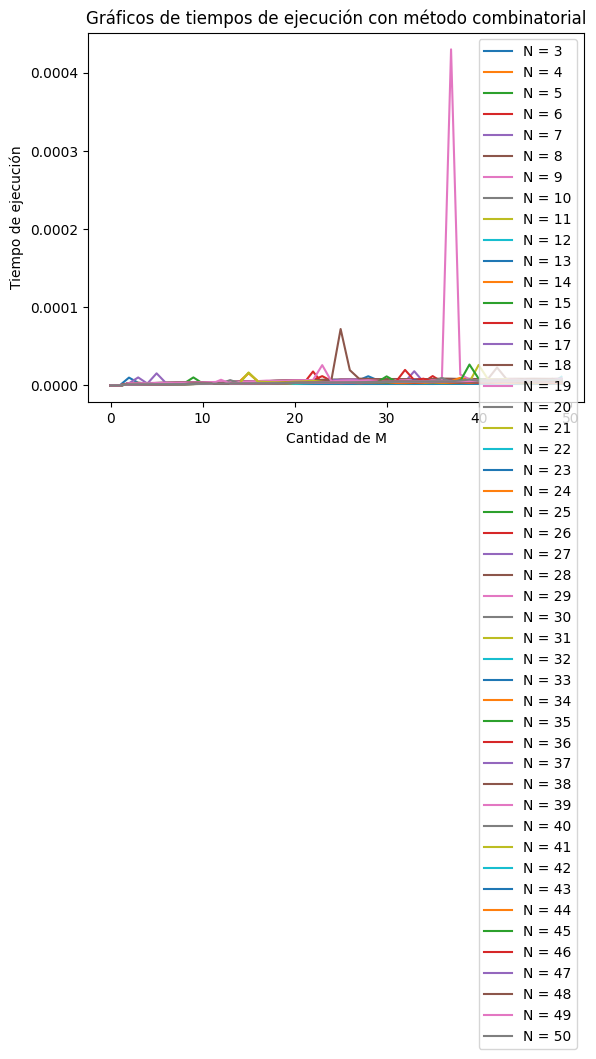

'Gráfs ok'

In [101]:
G1 = tarea1(50,50)
G1.performance()
G1.show_performance()

Grilla iniciada de dimensiones 12x12


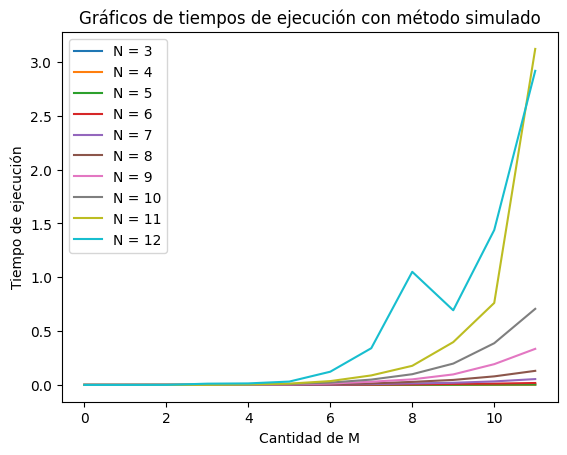

'Gráfs ok'

In [102]:
G1 = tarea1(12,12)
G1.performance(method='sim')
G1.show_performance()